In [4]:
import sys
sys.path.insert(0, '/Users/37138/.pyenv/versions/3.8.0/lib/python3.8/site-packages')
print(sys.path)
%load_ext autoreload
%autoreload 2

['/Users/37138/.pyenv/versions/3.8.0/lib/python3.8/site-packages', '/Users/37138/.pyenv/shims/python/site-packages', '/Users/37138/anaconda3/lib/python36.zip', '/Users/37138/anaconda3/lib/python3.6', '/Users/37138/anaconda3/lib/python3.6/lib-dynload', '', '/Users/37138/.local/lib/python3.6/site-packages', '/Users/37138/anaconda3/lib/python3.6/site-packages', '/Users/37138/anaconda3/lib/python3.6/site-packages/aeosa', '/Users/37138/anaconda3/lib/python3.6/site-packages/IPython/extensions', '/Users/37138/.ipython']
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
#import modules
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import sys
from geopy import distance
from shapely.geometry import Point
import geopandas
import geocoder
from tqdm import tqdm
import random
#import geopandas
%matplotlib inline

In [6]:
tqdm.pandas()

In [7]:
# import data
df_raw = pd.read_csv('RAW_DATA/SF-Housing-Sales.csv')
df_clean = pd.read_csv('ENG_DATA/11-25_Clean_df.csv',index_col=[0])

In [18]:
df_raw.columns

Index(['longitude', 'latitude', 'elevation', 'full_address', 'city', 'state',
       'street_no', 'street_name', 'street_suffix', 'zip', 'area',
       'district_no', 'district_desc', 'subdist_no', 'subdist_desc',
       'on_market_date', 'cdom', 'orig_list_price', 'sale_date', 'sale_price',
       'rooms', 'baths', 'beds', 'sf_source', 'sf_source_decs', 'sf',
       'lot_acres', 'lot_sf', 'year_built', 'zoning', 'lot_desc', 'drive_side',
       'parking', 'park_leased', 'num_parking', 'shopping', 'transportation',
       'type', 'views'],
      dtype='object')

In [22]:
df_raw['neighborhood'] = df_raw.apply(lambda x: x['subdist_desc'].split('- ')[1], axis=1)

In [8]:
#import 10% of crime data 
p = 0.1
df_crime = pd.read_csv(
         'RAW_DATA/Crime.csv',
         header=0, 
         skiprows=lambda i: i>0 and random.random() > p
)
df_crime = df_crime.drop('Location', 1)

In [11]:
# Add back sf and sf_plot to clean data
df_clean["sf"] = df_raw["sf"]
df_clean["lot_sf"] = df_raw["lot_sf"]

In [12]:
# Add year on-market, month on-market and year sold, month sold
def computeDateFunc(date, month_not_year): 
    date_format = "%m/%d/%y"
    a = datetime.strptime(date, date_format)
    if month_not_year: 
        return a.month
    else:
        return a.year

In [13]:
df_clean["on_market_year"] = df_clean["on_market_date"].apply(lambda x: computeDateFunc(x, False))
df_clean["on_market_month"] = df_clean["on_market_date"].apply(lambda x: computeDateFunc(x, True))
df_clean["sale_year"] = df_clean["sale_date"].apply(lambda x: computeDateFunc(x, False))
df_clean["sale_month"] = df_clean["sale_date"].apply(lambda x: computeDateFunc(x, True))

In [102]:
# EXPORT
df_clean.to_csv('ENG_DATA/11-25_Clean_df.csv')

In [11]:
#Fix a bug
df_crime.loc[df_crime['X']==-120.5, 'X'] = -122.4237179 

In [12]:
 # Crime mapping
df_crime['geometry'] = df_crime.apply(lambda row: Point(row['X'], row['Y']), axis=1)

In [13]:
geo_crime = geopandas.GeoDataFrame(df_crime, geometry='geometry')
geo_crime.crs = {'init': 'epsg:4326'}

In [14]:
# add crime data per zip code
sf = geopandas.read_file('RAW_DATA/sf.geojson')
sf.crs = {'init': 'epsg:4326'}
sf = sf.rename(columns={'geometry': 'geometry','nhood':'neighborhood_name'}).set_geometry('geometry')

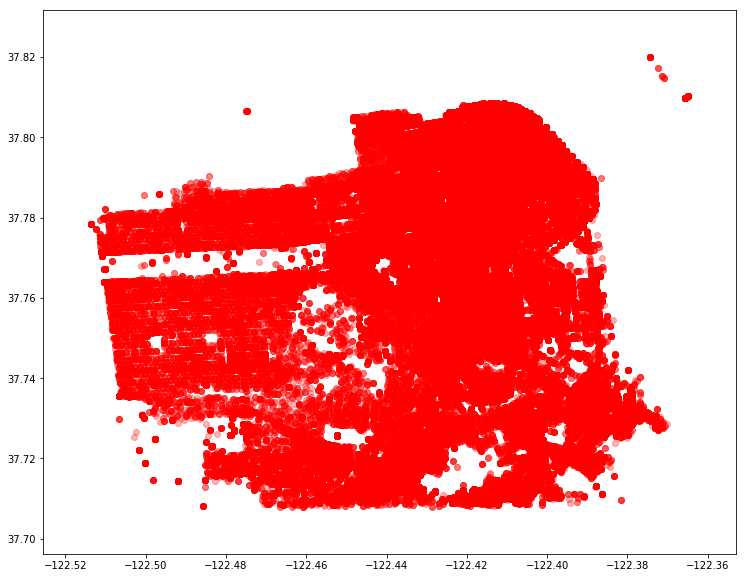

In [90]:
geo_crime.plot(figsize=(13,10), marker="o", color="red", alpha=0.3)

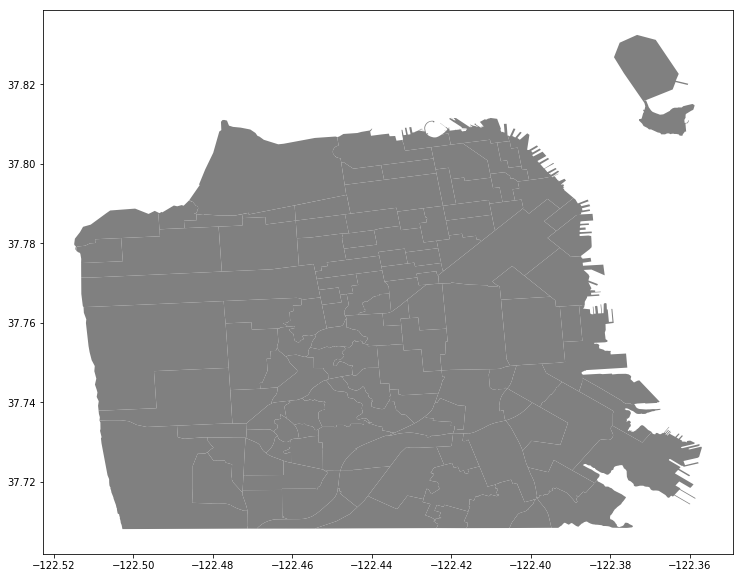

In [91]:
sf.plot(figsize=(13,10), color='gray')
plt.show()

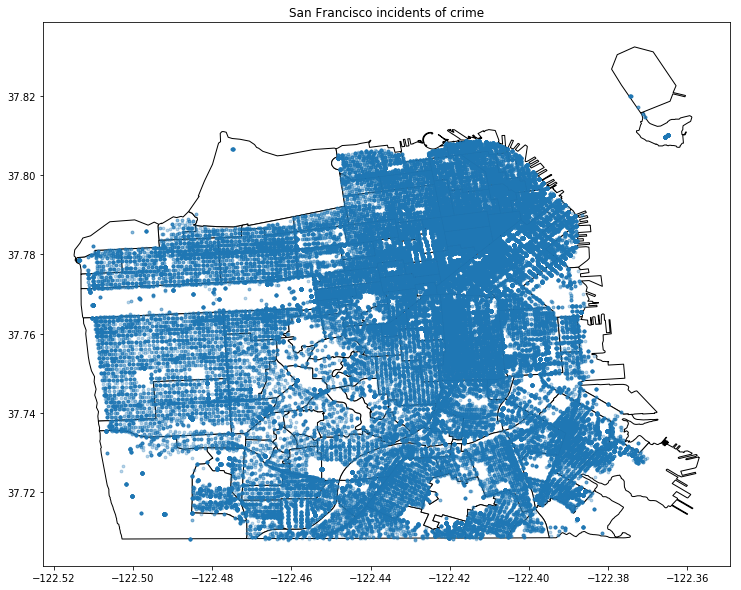

In [94]:
# fig, ax = plt.subplots(1, figsize=(13,10))
fig, ax = plt.subplots(1, figsize=(13,10))
sf_map = sf.plot(ax=ax, color='white', edgecolor='black')
geo_crime.plot(ax=sf_map, marker="o", markersize=8, alpha=0.3)
ax.set_title("San Francisco incidents of crime")
plt.show()

In [15]:
# Spatial join
combined = geopandas.tools.sjoin(geo_crime, sf, how='left')
combined.sample(5)

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,PdId,geometry,index_right,link,name
128583,146226730,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,10/27/2014,21:00,TARAVAL,NONE,19TH AV / SARGENT ST,-122.471571,37.716127,14622673006244,POINT (-122.47157 37.71613),64.0,http://en.wikipedia.org/wiki/Neighborhoods_in_...,Merced Heights
175586,76036792,LARCENY/THEFT,GRAND THEFT OF PROPERTY,Wednesday,05/23/2007,22:00,NORTHERN,NONE,MARKET ST / CHURCH ST,-122.428950,37.767503,7603679206374,POINT (-122.42895 37.76750),36.0,None,Mission Dolores
144920,150648978,FRAUD,"CREDIT CARD, THEFT OF",Saturday,07/25/2015,23:42,RICHMOND,"ARREST, BOOKED",ANZA ST / 7TH AV,-122.465212,37.779040,15064897809310,POINT (-122.46521 37.77904),4.0,http://www.sfgate.com/neighborhoods/sf/innerri...,Inner Richmond
85308,160666829,ROBBERY,"ROBBERY ON THE STREET, STRONGARM",Thursday,08/18/2016,08:41,BAYVIEW,NONE,1500 Block of REVERE AV,-122.389206,37.731189,16066682903014,POINT (-122.38921 37.73119),85.0,http://en.wikipedia.org/wiki/Neighborhoods_in_...,Bayview
98765,186045465,LARCENY/THEFT,GRAND THEFT OF PROPERTY,Thursday,02/22/2018,14:00,RICHMOND,NONE,700 Block of ARGUELLO BL,-122.458472,37.776705,18604546506374,POINT (-122.45847 37.77671),11.0,"http://en.wikipedia.org/wiki/Lone_Mountain,_Sa...",Lone Mountain


In [40]:
neighborhood_counts = combined.groupby('name')['IncidntNum'].count().reset_index()
neighborhood_counts.columns = ['name','num_incidents']
neighborhood_counts = neighborhood_counts.sort_values(by='num_incidents', ascending=False)

In [44]:
neighborhood_counts

,name,num_incidents
98,South of Market,29563
64,Mission,18785
106,Tenderloin,18730
25,Downtown / Union Square,7912
6,Bayview,6258
...,...,...
68,Monterey Heights,59
114,Westwood Highlands,44
107,Treasure Island,21
51,Lincoln Park / Ft. Miley,19


In [13]:
chloropleth_data = neighborhood_counts.merge(sf)
chloropleth_data = geopandas.GeoDataFrame(chloropleth_data, geometry='geometry')
chloropleth_data.crs = {'init': 'epsg:4326'}

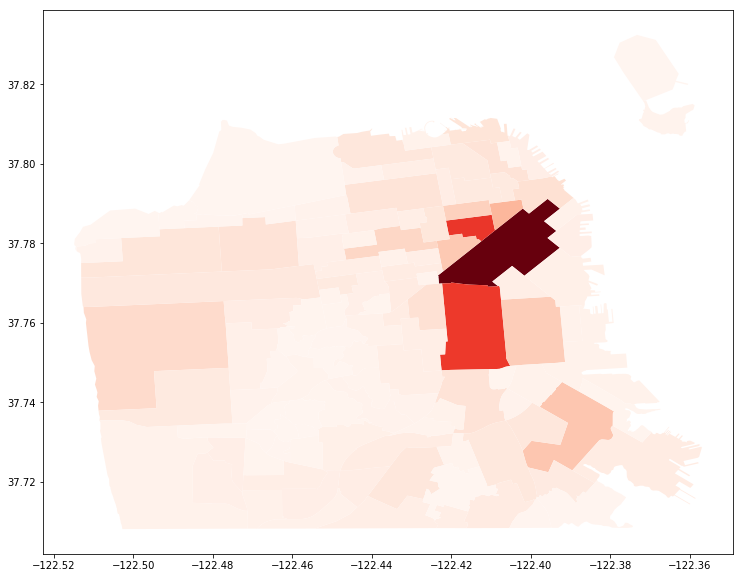

In [21]:
chloropleth_data.plot(column='num_incidents', cmap='Reds', figsize=(13,10))

In [ ]:
#spatial join between aggregated crime data and house location data 

In [32]:
# Crime mapping
df_clean['geometry'] = df_clean.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
geo_clean = geopandas.GeoDataFrame(df_clean, geometry='geometry')
geo_clean.crs = {'init': 'epsg:4326'}

In [33]:
combined2 = geopandas.tools.sjoin(geo_clean, sf, how='left')

In [37]:
combined2 = combined2.drop(columns = ["link", "index_right"], index=1)

In [47]:
df_clean_crime = combined2.merge(neighborhood_counts, how = 'left', on = 'name')

In [51]:
df_clean_crime.to_csv('ENG_DATA/12-1_Clean_df.csv')

In [ ]:
### Source: http://mattmurray.net/unlocking-the-power-of-geospatial-data-with-geopandas/